# Importing Data and Preprocessing (Same in All notebooks)

In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
data = pd.read_csv('/users/rohanchitte/downloads/Dataset_lyrics.csv_lyrics.csv')

In [3]:
filtered = data[data['lyrics'].notnull()]
filtered

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...,...
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


In [4]:
import nltk
from nltk.corpus import stopwords

cleaned = filtered.copy()

# Remove punctuation
cleaned['lyrics'] = cleaned['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')

# Remove song-related identifiers like [Chorus] or [Verse]
cleaned['lyrics'] = cleaned['lyrics'].str.replace("\[(.*?)\]", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace("' | '", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace('x[0-9]+', ' ')

# Remove all songs without lyrics (e.g. instrumental pieces)
cleaned = cleaned[cleaned['lyrics'].str.strip().str.lower() != 'instrumental']

# Remove any songs with corrupted/non-ASCII characters, unavailable lyrics
cleaned = cleaned[~cleaned['lyrics'].str.contains(r'[^\x00-\x7F]+')]
cleaned = cleaned[cleaned['lyrics'].str.strip() != '']
cleaned = cleaned[cleaned['genre'].str.lower() != 'not available']

#Selecting Pop, Rock, Country, Jazz
cleaned = cleaned.loc[(cleaned['genre'] == 'Pop') | 
            (cleaned['genre'] == 'Country') |
            (cleaned['genre'] == 'Rock') |
            (cleaned['genre'] == 'Hip-Hop') |
            (cleaned['genre'] == 'Jazz') ]
cleaned.reset_index(inplace = True)

cleaned
print(len(cleaned))

from nltk.corpus import stopwords
stop = stopwords.words('english')
#removing stop words from lyrics

cleaned['lyrics'] = cleaned['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#lemmatizing lyrics
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text, flg_lemm=True):
    #Convert string to list (tokenize)
    lst_text = text.split()

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
        
    ## back to string from list
    text = " ".join(lst_text)
    return text
    
#cleaned["lyrics"] = cleaned["lyrics"].apply(lemmatize_text)

cleaned["lyrics"]  = cleaned["lyrics"].apply(lambda x:  lemmatize_text(x))

df = cleaned.drop(labels=["level_0", "index","song","year","artist"], axis=1)

185493


# Splitting Data into training and test set (Same as LSTM-GLOVE notebook)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [7]:
df_train.reset_index() 
df_test.reset_index() 

,index,genre,lyrics
0,35835,Jazz,I dance ask I dance ask I dance madame My hear...
1,2538,Hip-Hop,Sonic boom head dread cause he's tread Upon Fl...
2,63159,Rock,If I could turn page In time I'd rearrange Jus...
3,6483,Rock,record stop stop skipping equipped stor ear fu...
4,15496,Hip-Hop,Hey yeah ya know I like playersNo Diggity No d...
...,...,...,...
61208,10254,Hip-Hop,We're never done found place belong Don't stan...
61209,31630,Country,It's fake hoax nowhere road one go anywhere an...
61210,107267,Rock,I've spent much time throwing rock window That...
61211,67806,Rock,You're lookin fine long time I still remember ...


In [8]:
#train_test split
x_tr, y_tr = df_train['lyrics'].values, df_train['genre'].values
x_val, y_val = df_test['lyrics'].values, df_test['genre'].values

# Function to calculcate max length of the sequence in the corpus (Same as LSTM-GLOVE notebook)

In [9]:
def get_max_length(df_train):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to LSTM cell
    """
    max_length = 0
    for row in df_train['lyrics']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length


In [10]:
maximumlen = get_max_length(df_train)
maximumlen

3666

# One hot encoding genres (Same as LSTM-GLOVE notebook)

In [11]:
def genre_encode(genre):
    """
    return one hot encoding for Y value
    """
    if genre == 'Pop':
        return [1,0,0,0,0]
    elif genre == 'Rock':
        return [0,1,0,0,0]
    elif genre == 'Country':
        return [0,0,1,0,0]
    elif genre == 'Hip-Hop':
        return [0,0,0,1,0]
    else:
        return [0,0,0,0,1]

In [12]:
genres = df_train['genre'].tolist()
y_tr = [genre_encode(genre) for genre in genres]

In [13]:
genres = df_test['genre'].tolist()
y_val = [genre_encode(genre) for genre in genres]

# Tokenization and Padding of the sequences to make their length same (Same as LSTM-GLOVE notebook)

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=maximumlen)
x_val_seq = pad_sequences(x_val_seq, maxlen=maximumlen)

# Loading Pretrained Glove Word Embedding (Same as LSTM-GLOVE notebook)

In [15]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/users/rohanchitte/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [16]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

220815


# Creating a weight matrix for words in training docs (Same as LSTM-GLOVE notebook)

In [17]:

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM Model  (Same as LSTM-GLOVE notebook)

In [18]:
#deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [19]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=maximumlen,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(5,activation='softmax')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"]) 

#Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  

#mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3666, 300)         66244500  
_________________________________________________________________
lstm (LSTM)                  (None, 3666, 128)         219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 66,472,729
Trainable params: 228,229
Non-trainable params: 66,244,500
_________________________________________________________________
None


# Loading LSTM MODEL and Confusion Matrix 

In [21]:
model.load_weights("lyrics-5-categories-model-glove.h5")

In [22]:
predict = model.predict(np.array(x_val_seq))

In [23]:
from numpy import argmax
predictions = [argmax(values) for values in predict]

In [24]:
target_names = ["Pop", "Rock", "Country", "Hip-Hop", "Jazz"]

In [25]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [26]:
def genre_encode(genre):
    """
    return one hot encoding for Y value
    """
    if genre == 'Pop':
        return 0
    elif genre == 'Rock':
        return 1
    elif genre == 'Country':
        return 2
    elif genre == 'Hip-Hop':
        return 3
    else:
        return 4
    
genres = df_test['genre'].tolist()
y_val = [genre_encode(genre) for genre in genres]

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confmat = confusion_matrix(y_val, predictions)

LSTM GLOVE MODEL CONFUSION MATRIX


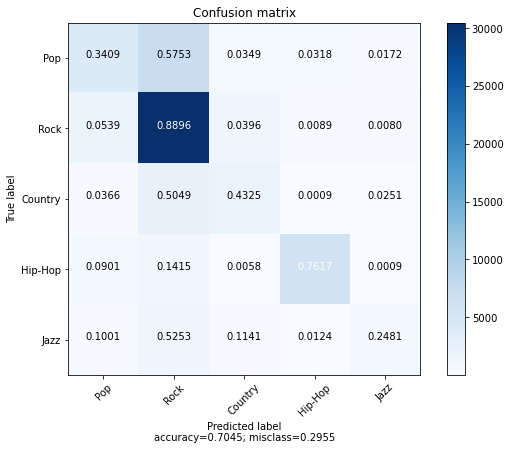

In [29]:
print("LSTM GLOVE MODEL CONFUSION MATRIX")
plot_confusion_matrix(confmat,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)